# Sklearn PCA

In [1]:
from sklearn import datasets

digits = datasets.load_digits()
print(digits.keys())
X = digits['data']
y = digits['target']

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #Automatically centers data around origin

X2D = pca.fit_transform(X)

dict_keys(['target', 'DESCR', 'images', 'data', 'target_names'])


In [2]:
X2D.shape

(1797, 2)

In [3]:
pca.components_

array([[-1.18594440e-17, -1.73094646e-02, -2.23428832e-01,
        -1.35913305e-01, -3.30323150e-02, -9.66340809e-02,
        -8.32943209e-03,  2.26900229e-03, -3.20516536e-04,
        -1.19308910e-01, -2.44451684e-01,  1.48512744e-01,
        -4.67319538e-02, -2.17740743e-01, -1.48136677e-02,
         4.47779647e-03, -4.94136705e-05, -7.95419489e-02,
         8.33951336e-02,  2.15915352e-01, -1.72126815e-01,
        -1.63712096e-01,  2.86444543e-02,  4.23251849e-03,
         9.85488411e-05,  6.42319049e-02,  2.54093308e-01,
        -3.56770921e-02, -2.09462580e-01, -4.31311399e-02,
         5.13118743e-02,  2.13422752e-04,  0.00000000e+00,
         1.59950878e-01,  3.68690773e-01,  1.64406827e-01,
         8.52007812e-02,  3.72982748e-02,  2.15866942e-02,
         0.00000000e+00,  1.28865586e-03,  1.06945285e-01,
         3.03067457e-01,  2.47813034e-01,  2.09637298e-01,
         1.22325150e-02, -3.69458535e-02,  1.61485045e-03,
         6.93023594e-04, -8.35144042e-03, -5.58598917e-0

In [4]:
pca.explained_variance_ratio_

array([0.14890594, 0.13618771])

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

In [6]:

pca=PCA()
pca.fit(X_train)

import numpy as np
cumulative_sum=np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumulative_sum>= 0.95) + 1

In [7]:
d

28

The code above calculates all principal components, and includes enough principal components such that the cumulative sum of variance ratio is >= 95% of total variance. This gives the number of principal components that should be included to best represent the original data.

We could fit another PCA with n_components=29 but instead, we can also choose a decimal between 0 and 1 such as 0.95 to automatically preserve 95% variance

In [8]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

64


Text(0, 0.5, 'Cumulative Explained Variance')

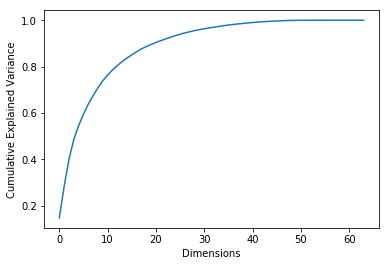

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
print(cumulative_sum.shape[0])
plt.plot(range(cumulative_sum.shape[0]), cumulative_sum)
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Explained Variance")

## PCA for Compression and Reconstruction

In [10]:
pca = PCA(n_components=0.95) #Compressed to use first 154 principal components
x_reduced = pca.fit_transform(X_train)
x_recovered = pca.inverse_transform(x_reduced)

In [11]:
pca.n_components_

28

In [12]:
x_reduced.shape

(1437, 28)

In [13]:
x_recovered.shape

(1437, 64)

## Incremental Principal Component Analysis

PCA requires that the entire dataset be available in memory. Incremental PCA is an online mini-batch approach.

In [14]:
from sklearn.decomposition import IncrementalPCA
n_batch=100
inc_pca = IncrementalPCA(n_components=15)

In [15]:
for X_batch in np.array_split(X_train, n_batch):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

/home/edwardchaos/.local/share/virtualenvs/TF_py3/lib/python3.5/site-packages/sklearn/decomposition/incremental_pca.py:271: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/edwardchaos/.local/share/virtualenvs/TF_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Using Numpy's memmap class instead, we can keep the dataset in a binary file and numpy would load it in memory only when needed. It abstracts away the fact that not the entire dataset is in memory. This is not an online technique.

In [16]:
"""
import numpy as np
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))
#What happens if datatype is set to 64, does it just break?
#Binary file ay?? how do you save such a file

batch_size = m
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc.fit(X_mm)
"""

'\nimport numpy as np\nX_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))\n#What happens if datatype is set to 64, does it just break?\n#Binary file ay?? how do you save such a file\n\nbatch_size = m\ninc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)\ninc.fit(X_mm)\n'

## Randomized PCA

Approximates the first d principal components

Much faster than previous PCAs when d is much smaller than n,
d - dimensionality
n - training instances

In [17]:
rnd_pca = PCA(n_components=29, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

# Kernel PCA 4 Non-Linear Projections

In [18]:
from sklearn.decomposition import KernelPCA

ker_pca = KernelPCA(n_components=29,kernel="rbf",gamma=0.04)
X_reduced = ker_pca.fit_transform(X_train)

Using Gridsearch to find the best kernel and gamma value

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", Imputer()),
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03,0.05,10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
X.shape
y.shape
print(np.any(np.isnan(X)),
np.any(np.isnan(y)),
np.all(np.isfinite(X)),
np.all(np.isfinite(y)))
grid_search.fit(X.astype(np.float64), y.astype(np.float64))


False False True True


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, ker...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__kernel': ['rbf', 'sigmoid'], 'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
print (grid_search.best_params_)

{'kpca__kernel': 'rbf', 'kpca__gamma': 0.04111111111111111}


Inversing transform using an rbf kernel is not as easy as linear pca and actually cannot be exactly done. An approximation can be done though with the code below

In [28]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [29]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X,X_preimage)

18.762041177809053

# Locally Linear Embedding (LLE)

In [36]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

The basic idea is to preserve the relationship between local points in a lower dimensional space.

How it's done:
1. Given a point and it's k nearest neighbors, the point is expressed as a linear combination of its knn with corresponding coefficients stored in weight vector w.

    This is done by solving a constrained optimization problem.

2. Now that we have the relation represented in vector w, we can use it to estimate the position of the point in a lower dimension. 

    This is an unconstrained optimization problem